# Inference notenook for [CLIP Trasnformer caption](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [16]:
#@title Install
! pip install transformers
! pip install git+https://github.com/openai/CLIP.git

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-73s8d3mh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-73s8d3mh
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [16]:
#@title Imports
import clip, json
import os, sys
from torch import nn
import numpy as np
import torch, nltk
import pickle
import torch.nn.functional as nnf
from typing import Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score, single_meteor_score
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image 
from enum import Enum
#nltk.download('wordnet')
#nltk.download('punkt')

D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
print(current_directory)
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'weights_transformer.pt')
model_path1 = "/home/apassadaki/data/admitosstorage/pretrained_models/MSCOCO/Transformer/weights_transformer.pt"
model_path2 = "/home/apassadaki/data/admitosstorage/pretrained_models/MSCOCO/Transformer_prefix_GPT/coco_prefix-009.pt"
print(model_path)

/data/admitosstorage/code
/data/admitosstorage/pretrained_models/weights_transformer.pt


In [17]:
#@title Model
class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'

class MlpTransformer(nn.Module):
     
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)
         self.act = act
         self.fc2 = nn.Linear(h_dim, out_d)
         self.dropout = nn.Dropout(dropout)

     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x

class MLP(nn.Module):

    def __init__(self, sizes, bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self//num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x


class Transformer(nn.Module):

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers*2
        layers = []
        for i in range(num_layers):
            if i%2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x


class TransformerMapper(nn.Module):

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.dim_embedding = dim_embedding
        self.dim_clip = dim_clip
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out


class ClipCaptionModel(nn.Module):

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512, num_layers: int=8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size*prefix_length)//2, self.gpt_embedding_size*prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length, clip_length, num_layers)

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None, labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [18]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None, entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores/seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(model, tokenizer, tokens=None, prompt=None, embed=None,
        entry_count=1, entry_length=67,  # maximum number of words
        top_p=0.8, temperature=1., stop_token: str = '.'):
    
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [24]:
#@title CLIP model + GPT2 tokenizer
#@title GPU/CPU
is_gpu = True #@param {type:"boolean"}  
my_device = CUDA(0) if is_gpu else "cpu"
print(my_device)
clip_model, preprocess = clip.load("RN50x4", device=my_device, jit=False)
#clip_model, preprocess = clip.load("ViT-B/32", device=my_device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

cuda:0


In [25]:
# The pretrained model was saved with ReSNet image encoder and the parameters: prefix_length=40, clip_length=40, prefix_size=640 and num_layers=8.
#@title Load model weights
prefix_length = 40
model = ClipCaptionPrefix(prefix_length, clip_length=40, prefix_size=640, num_layers=8, mapping_type='transformer') # prefix_size=640 for ResNet and 512 for ViT
#model = ClipCaptionPrefix(prefix_length, clip_length=10, prefix_size=512, num_layers=4, mapping_type='transformer') 
my_weights = torch.load(model_path1, map_location=my_device)
for i in range(12):
    name1 = 'gpt.transformer.h.' + str(i) + '.attn.bias'
    name2 = 'gpt.transformer.h.' + str(i) + '.attn.masked_bias'
    my_weights.pop(name1)
    my_weights.pop(name2)
#print(my_weights.keys())
model.load_state_dict(my_weights) 
model = model.eval() 
model = model.to(my_device)

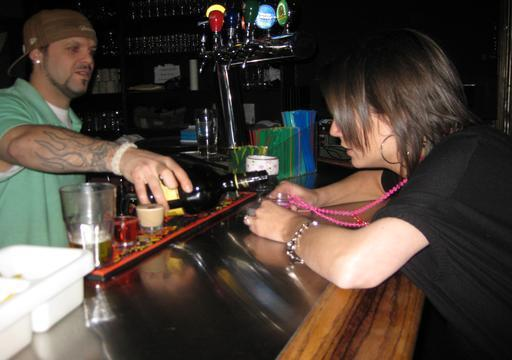

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]



A man and woman are at a bar.


In [26]:
#@title Inference
use_beam_search = False #@param {type:"boolean"}  
my_img_path = "/data/admitosstorage/yingjin_images/" + "/image_100.jpg"
#my_img_path = "C:/Users/admitos/Desktop/ThesisUU/vist_yingjin_images/" + "/image_100.jpg"
image = io.imread(my_img_path)
pil_image = PIL.Image.fromarray(image)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(my_device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(my_device, dtype=torch.float32)
    prefix = prefix/prefix.norm(2, -1).item()
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

print('\n')
print(generated_text_prefix)

### Run the pre-trained model on Vist Test set

In [27]:
# path_to_train_dii_sis = '/data/admitosstorage/DII-SIS/dii_sis_train_annots.json'
# with open(path_to_train_dii_sis, 'r', encoding='utf-8') as f:
#     train_data = json.load(f)

# path_to_val_dii_sis = '/data/admitosstorage/DII-SIS/dii_sis_val_annots.json'
# with open(path_to_val_dii_sis, 'r', encoding='utf-8') as f:
#     val_data = json.load(f)

# path_to_test_dii_sis = '/data/admitosstorage/DII-SIS/dii_sis_test_annots.json'
# with open(path_to_test_dii_sis, 'r', encoding='utf-8') as f:
#     test_data = json.load(f)
path_to_test_dii = '/data/admitosstorage/DII-annotation/test.description-in-isolation.json'
with open(path_to_test_dii, 'r', encoding='utf-8') as f:
    test_data = json.load(f)['annotations']

path_to_val_dii = '/data/admitosstorage/DII-annotation/val.description-in-isolation.json'
with open(path_to_val_dii, 'r', encoding='utf-8') as f:
    val_data = json.load(f)['annotations']
    
path_to_train_dii = '/data/admitosstorage/DII-annotation/train.description-in-isolation.json'
with open(path_to_train_dii, 'r', encoding='utf-8') as f:
    train_data = json.load(f)['annotations']

In [29]:
folder_path = '/data/admitosstorage/all_train_images/'
test_dicts = []
train_dicts = []
val_dicts = []
for i,filename in enumerate(os.listdir(folder_path)):
    if filename.endswith(".jpg"):
        my_img_path = os.path.join(folder_path,filename)
        #flag_test = False
        #flag_val = False
        flag_train = False
        ###########################################################################
        # for my_item in test_data:
        #     if my_item[0]['photo_flickr_id'] == filename[:-4]:
        #         test_dicts.append(my_item[0])
        #         flag_test = True
        # if not flag_test:
        #     print("We did not found the image on the TEST Set: ", filename)
        ##########################################################################
        # for my_item in val_data:
        #     if my_item[0]['photo_flickr_id'] == filename[:-4]:
        #         val_dicts.append(my_item[0])
        #         flag_val = True
        #if not flag_val:
            #print("We did not found the image on the VAL Set: ", filename)
        ##########################################################################
        for my_item in train_data:
            if my_item[0]['photo_flickr_id'] == filename[:-4]:
                train_dicts.append(my_item[0])
                flag_train = True
        #if not flag_train:
        #    print("We did not found the image on the TRAIN Set: ", filename)
    if i%100==0:
        print("On iteration {}:".format(i))
        # print("-------------------------------------------------------------------------------------------------------------------------------")
        # print("The length of the test_dicts is:", len(test_dicts))
        # print("---------------------------------------------")
        #print("The length of the val_dicts is:", len(val_dicts))
        # print("---------------------------------------------")
        print("The length of the train_dicts is:", len(train_dicts))
        print("--------------------------------------------------------------------------------------------------------------------------------")
        print()

On iteration 0:
The length of the train_dicts is: 0
--------------------------------------------------------------------------------------------------------------------------------

On iteration 100:
The length of the train_dicts is: 72
--------------------------------------------------------------------------------------------------------------------------------

On iteration 200:
The length of the train_dicts is: 159
--------------------------------------------------------------------------------------------------------------------------------

On iteration 300:
The length of the train_dicts is: 252
--------------------------------------------------------------------------------------------------------------------------------

On iteration 400:
The length of the train_dicts is: 342
--------------------------------------------------------------------------------------------------------------------------------

On iteration 500:
The length of the train_dicts is: 417
-------------------

In [37]:
print(len(train_dicts))

119088


In [33]:
my_original_dict = {}
flicker_ids = [item['photo_flickr_id'] for item in train_dicts]
print(len(flicker_ids))
unique_flicker_ids = list(set(flicker_ids))
print(len(unique_flicker_ids))
for j,id in enumerate(unique_flicker_ids):
    my_original_dict[id] = [item['original_text'] for item in train_dicts if item['photo_flickr_id']==id] 
    if j%100==0:
        print("On iteration {}:".format(j))
        print("--------------------------------------------------------------------------------------------------------------------")

119088
39696
On iteration 0:
--------------------------------------------------------------------------------------------------------------------
On iteration 100:
--------------------------------------------------------------------------------------------------------------------
On iteration 200:
--------------------------------------------------------------------------------------------------------------------
On iteration 300:
--------------------------------------------------------------------------------------------------------------------
On iteration 400:
--------------------------------------------------------------------------------------------------------------------
On iteration 500:
--------------------------------------------------------------------------------------------------------------------
On iteration 600:
--------------------------------------------------------------------------------------------------------------------
On iteration 700:
--------------------------

In [38]:
print(list(my_original_dict.items())[0])

('13283814', ['This looks like the start of a bike race, it is very congested.', 'A group of bikers that are racing on the streets.', 'Large group of cyclists in uniform making a turn.'])


In [17]:
original_dict_path = '/data/admitosstorage/results/zero-shot/original_dict_val.json'
# my_original_dict = {}
# flicker_ids = [item['photo_flickr_id'] for item in test_dicts]
# print(len(flicker_ids))
# unique_flicker_ids = list(set(flicker_ids))
# print(len(unique_flicker_ids))
# for id in unique_flicker_ids:
#     my_original_dict[id] = [item['description'] for item in test_dicts if item['photo_flickr_id']==id] 

with open(original_dict_path, 'w', encoding='utf-8') as json_file:
    json.dump(my_original_dict, json_file, ensure_ascii=False, indent=4)

4949


In [18]:
#print(my_original_dict)
# print(my_original_dict['6171461'])
# print(my_original_dict['4411672897'])
#print(my_original_dict.keys())
for i, filename in enumerate(os.listdir(folder_path)):
    if filename[:-4] not in my_original_dict.keys():
        if i%10==0:
            print("Iteration: {} --> The image with photo_id: {}, has not be found".format(i,filename))
        continue 
    else:
        my_img_path = os.path.join(folder_path,filename)
        image = io.imread(my_img_path)
        pil_image = PIL.Image.fromarray(image)
        if i%10==0:
            print("Iteration: {} --> Managed to find and process image with photo_id: {}".format(i,filename))


Iteration: 0 --> Managed to find and process image with photo_id: 1001024065.jpg
Iteration: 10 --> Managed to find and process image with photo_id: 10036573.jpg
Iteration: 20 --> The image with photo_id: 10037689.jpg, has not be found
Iteration: 30 --> The image with photo_id: 1003892528.jpg, has not be found
Iteration: 40 --> The image with photo_id: 1012269332.jpg, has not be found
Iteration: 50 --> Managed to find and process image with photo_id: 1012271528.jpg
Iteration: 60 --> Managed to find and process image with photo_id: 1012442977.jpg
Iteration: 70 --> The image with photo_id: 1015974221.jpg, has not be found
Iteration: 80 --> The image with photo_id: 1015975795.jpg, has not be found
Iteration: 90 --> The image with photo_id: 1015976889.jpg, has not be found
Iteration: 100 --> The image with photo_id: 1016834862.jpg, has not be found
Iteration: 110 --> The image with photo_id: 1016837360.jpg, has not be found
Iteration: 120 --> The image with photo_id: 101717260.jpg, has not 

In [57]:
use_beam_search = True #@param {type:"boolean"} 
my_generated_dict = {}
for i, filename in enumerate(os.listdir(folder_path)):
    if i == 19483:
        continue
    else:
        if filename[:-4] not in my_original_dict.keys():
            print("Iteration: {} --> The image with photo_id: {}, has not be found".format(i,filename))
            continue 
        if filename.endswith(".jpg"):  
            my_img_path = os.path.join(folder_path,filename)
            
            image = io.imread(my_img_path)
            pil_image = PIL.Image.fromarray(image)
            # display(pil_image)
    
            image = preprocess(pil_image).unsqueeze(0).to(my_device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).to(my_device, dtype=torch.float32)
                prefix = prefix/prefix.norm(2,-1).item()
                prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
            if use_beam_search:
                generated_caption = generate_beam(model, tokenizer, embed=prefix_embed)[0]
            else:
                generated_caption = generate2(model, tokenizer, embed=prefix_embed)
    
            print("Iteration: {} --> For the image with photo_id: {}, the generated caption is: {}".format(i,filename,generated_caption))
            my_generated_dict[filename[:-4]] = generated_caption

Iteration: 0 --> The image with photo_id: 10125768854.jpg, has not be found
Iteration: 1 --> For the image with photo_id: 10125833745.jpg, the generated caption is: A group of people sit on a street corner.
Iteration: 2 --> For the image with photo_id: 10125853125.jpg, the generated caption is: A man and a woman pose for a picture while a woman takes a picture.
Iteration: 3 --> For the image with photo_id: 10125871905.jpg, the generated caption is: A man standing in front of a large statue of a king.
Iteration: 4 --> The image with photo_id: 10125874236.jpg, has not be found
Iteration: 5 --> The image with photo_id: 10125941016.jpg, has not be found
Iteration: 6 --> The image with photo_id: 10125952003.jpg, has not be found
Iteration: 7 --> The image with photo_id: 10125972323.jpg, has not be found
Iteration: 8 --> For the image with photo_id: 10125979553.jpg, the generated caption is: A group of people are sitting at a table.
Iteration: 9 --> For the image with photo_id: 10125983463.j

In [39]:
print(len(my_generated_dict))
#unique_flicker_ids.remove('764378')
print(len(unique_flicker_ids))
#my_original_dict.pop('764378')
print(len(my_original_dict))

4992
4992
4992


### Calculate metrics (BLEU and METEOR)

In [41]:
## These scores are from the transformer model with the use of beam_search
chencherry  = nltk.translate.bleu_score.SmoothingFunction()
for j, id in enumerate(unique_flicker_ids):
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(1, 0, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-1 score -> {}'.format(j,b_score))
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-2 score -> {}'.format(j,b_score))
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-4 score -> {}'.format(j,b_score))
    #splitted_list = [item.split() for item in my_original_dict[id]]
    #m_score = round(meteor_score(splitted_list, my_generated_dict[id].split()),5)
    #print(f"On iteration {j}, METEOR-score -> {m_score}")
    print()


On iteration 0, BLEU-1 score -> 0.94595
On iteration 0, BLEU-2 score -> 0.79412
On iteration 0, BLEU-4 score -> 0.46862

On iteration 1, BLEU-1 score -> 0.9375
On iteration 1, BLEU-2 score -> 0.81132
On iteration 1, BLEU-4 score -> 0.58488

On iteration 2, BLEU-1 score -> 0.81561
On iteration 2, BLEU-2 score -> 0.74882
On iteration 2, BLEU-4 score -> 0.55007

On iteration 3, BLEU-1 score -> 0.60575
On iteration 3, BLEU-2 score -> 0.51711
On iteration 3, BLEU-4 score -> 0.37472

On iteration 4, BLEU-1 score -> 0.85417
On iteration 4, BLEU-2 score -> 0.73839
On iteration 4, BLEU-4 score -> 0.58998

On iteration 5, BLEU-1 score -> 0.98
On iteration 5, BLEU-2 score -> 0.87178
On iteration 5, BLEU-4 score -> 0.68089

On iteration 6, BLEU-1 score -> 0.91837
On iteration 6, BLEU-2 score -> 0.75761
On iteration 6, BLEU-4 score -> 0.46159

On iteration 7, BLEU-1 score -> 0.96154
On iteration 7, BLEU-2 score -> 0.86842
On iteration 7, BLEU-4 score -> 0.60387

On iteration 8, BLEU-1 score -> 0.88

In [31]:
## These scores are from the transformer model without using beam_search
chencherry  = nltk.translate.bleu_score.SmoothingFunction()
bleu1 = []
bleu2 = []
bleu4 = []
for j, id in enumerate(unique_flicker_ids):
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(1, 0, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-1 score -> {}'.format(j,b_score))
    bleu1.append(b_score)
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-2 score -> {}'.format(j,b_score))
    bleu2.append(b_score)
    b_score = round(sentence_bleu(my_original_dict[id], my_generated_dict[id], weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1),5)
    print('On iteration {}, BLEU-4 score -> {}'.format(j,b_score))
    bleu4.append(b_score)
    #splitted_list = [item.split() for item in my_original_dict[id]]
    #m_score = round(meteor_score(splitted_list, my_generated_dict[id].split()),5)
    #print(f"On iteration {j}, METEOR-score -> {m_score}")
    print()


On iteration 0, BLEU-1 score -> 0.94595
On iteration 0, BLEU-2 score -> 0.79412
On iteration 0, BLEU-4 score -> 0.46862

On iteration 1, BLEU-1 score -> 0.73553
On iteration 1, BLEU-2 score -> 0.67695
On iteration 1, BLEU-4 score -> 0.59443

On iteration 2, BLEU-1 score -> 0.81435
On iteration 2, BLEU-2 score -> 0.6299
On iteration 2, BLEU-4 score -> 0.2836

On iteration 3, BLEU-1 score -> 0.76119
On iteration 3, BLEU-2 score -> 0.65874
On iteration 3, BLEU-4 score -> 0.45124

On iteration 4, BLEU-1 score -> 0.85417
On iteration 4, BLEU-2 score -> 0.73839
On iteration 4, BLEU-4 score -> 0.58998

On iteration 5, BLEU-1 score -> 0.98
On iteration 5, BLEU-2 score -> 0.87178
On iteration 5, BLEU-4 score -> 0.70898

On iteration 6, BLEU-1 score -> 0.80987
On iteration 6, BLEU-2 score -> 0.68801
On iteration 6, BLEU-4 score -> 0.39744

On iteration 7, BLEU-1 score -> 0.95
On iteration 7, BLEU-2 score -> 0.84171
On iteration 7, BLEU-4 score -> 0.56275

On iteration 8, BLEU-1 score -> 0.86047


In [34]:
import pickle

print(len(bleu1))
print(len(bleu2))
print(len(bleu4))

results_path1 = '/data/admitosstorage/results/zero-shot/Transformer/bleu1_no_beam.pkl'
results_path2 = '/data/admitosstorage/results/zero-shot/Transformer/bleu2_no_beam.pkl'
results_path4 = '/data/admitosstorage/results/zero-shot/Transformer/bleu4_no_beam.pkl'

with open(results_path1, 'wb') as f:
    pickle.dump(bleu1, f)

with open(results_path2, 'wb') as f:
    pickle.dump(bleu2, f)

with open(results_path4, 'wb') as f:
    pickle.dump(bleu4, f)

4992
4992
4992
